# Dependencies

## Imports

In [1]:
# imports 
# base python
import os
import copy
from sys import getsizeof

# scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d
from sklearn import preprocessing
from scipy.signal import find_peaks

import matplotlib.tri as tri

plt.rcParams["figure.figsize"] = (20,7)

class units():
    fs = 0.02418884326505
    angstrom = 0.52917720859
    eV = 27.21138386
    kcal_mol = 627.509470
    kj_mol = 2625.499625

## Functions

In [2]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
# https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array

def detect_peaks2D(image, sizeparam):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
#     local_max = maximum_filter(image, footprint=neighborhood)==image
    local_max = maximum_filter(image, size = (sizeparam, sizeparam))==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks


# FES plotting

Plot fes curves and find critical points

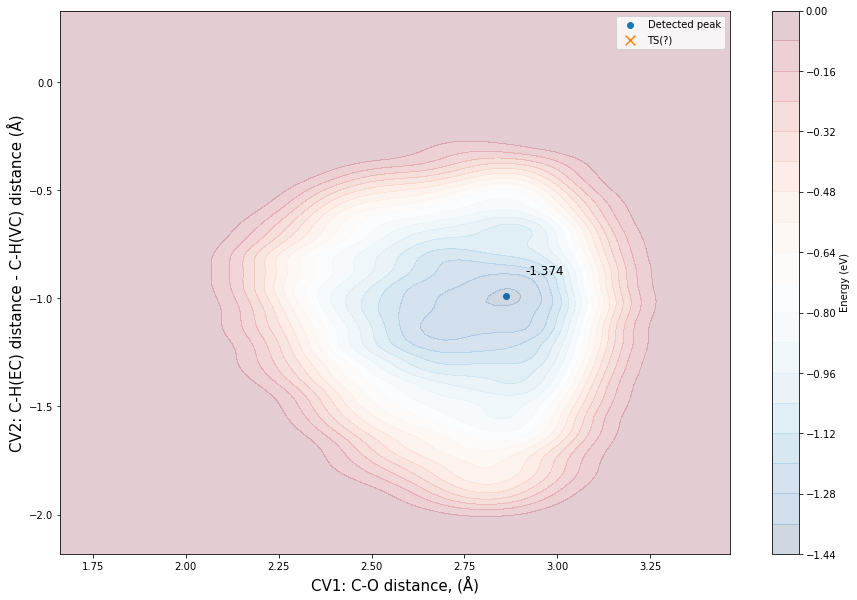

In [3]:
ndim = 2 # set me!!! 

dataloc = "../vcproj/cv2+htransf/1/continue/"

if ndim == 1:
    numFES = 7
    dataFES = [pd.read_csv(dataloc + "fes.dat.%d" % i, header = None, sep = "\s+")
               for i in range(1, numFES + 1)]
    finalFES = dataFES[-1]
    for i, data in enumerate(dataFES):
        data.columns = ["CV", "E"]
        plt.plot(np.array(data["CV"]), data["E"], label = "fes.dat %d" % i)
        plt.legend()
    maxpoints = find_peaks(finalFES["E"], threshold = 1E-5)[0]
    minpoints = find_peaks(-finalFES["E"], threshold = 1E-5)[0]
    # plt.plot(finalFES["CV"], finalFES["E"])
    plt.scatter(finalFES["CV"][maxpoints].iloc[0], finalFES["E"][maxpoints].iloc[0])
    plt.scatter(finalFES["CV"][minpoints].iloc[:2], finalFES["E"][minpoints].iloc[:2]);

    barrierE = finalFES["E"][maxpoints].iloc[0]
    initialE = finalFES["E"][minpoints].iloc[0]
    finalE = finalFES["E"][minpoints].iloc[1]
    print("Initial energy: %.5f eV; Final energy: %.5f eV; Free energy barrier: %.5f eV" 
          % ((initialE * units.eV, finalE* units.eV, (barrierE-initialE) * units.eV)))
elif ndim == 2:
    
    fig, ax = plt.subplots(figsize = (15,10))
    numFES = 7
    dataFES = [pd.read_csv(dataloc + "fes.dat.%d" % i, header = None, sep = "\s+")
               for i in range(1, numFES + 1)]
    finalFES = dataFES[-1]
    for i, data in enumerate(dataFES):
        data.columns = ["CV1", "CV2", "E"]
    finalFES["CV1"], finalFES["CV2"] = finalFES["CV1"] * units.angstrom, finalFES["CV2"]*units.angstrom
    finalFES["E"] = finalFES["E"]*units.eV
    Z = finalFES.pivot_table(index='CV1', columns='CV2', values='E').T.values

    
    X_unique = np.sort(finalFES.CV1.unique())
    Y_unique = np.sort(finalFES.CV2.unique())
    
    Zfunc = interp2d(X_unique, Y_unique, Z, kind = 'linear')    
    X, Y = np.meshgrid(X_unique, Y_unique)

    cntr1 = ax.contourf(X, Y ,Z, levels=21, cmap="RdBu_r", zorder = 2, alpha = .2)
    peakarray = detect_peaks2D(-Z, 30)
    isnonzero = Z != 0
    validpeaks = peakarray & isnonzero
    plt.scatter(X[validpeaks], Y[validpeaks], label = "Detected peak")
    fig.colorbar(cntr1, label = "Energy (eV)")
    plt.xlabel("CV1: C-O distance, (Å)", fontsize = 15)
    plt.ylabel(r"CV2: C-H(EC) distance - C-H(VC) distance (Å)", fontsize = 15)
    
    zshape = Z.shape
    foundpeakarray = []
    for i in range(zshape[0]):
        for j in range(zshape[1]):
            if validpeaks[i,j]:
                foundpeakarray += [[X[i,j], Y[i,j], Z[i,j]]]
#     print("Found peaks: (CV1, CV2, E)") 
    foundpeakarray = np.array(foundpeakarray)
    
    barriers = np.array([])
    for i, peak1 in enumerate(foundpeakarray):
        for peak2 in foundpeakarray[i + 1:]:
            x1, y1, E1 = peak1
            x2, y2, E2 = peak2
            xpoints  = np.linspace(x1, x2, 50)
            ypoints = np.linspace(y1, y2, 50)
            zvals = [Zfunc(i,j)[0] for i,j in zip(xpoints, ypoints)]
            plt.plot(xpoints, ypoints, '--')
            maxpoints = find_peaks(zvals, threshold = 1E-5)[0]
            maxpoints = [i for i in maxpoints if zvals[i] == max(np.array(zvals)[maxpoints])]
            barriers = np.append(barriers, 
                                 [xpoints[maxpoints], ypoints[maxpoints], np.array(zvals)[maxpoints]])
    barriers = barriers.reshape((-1, 3))
    plt.scatter(barriers[:,0], barriers[:,1], marker = 'x', label = "TS(?)", s = 96)
    for i, barrier in enumerate(barriers[:, -1]):
        ax.annotate(round(barrier, 3), (barriers[i, 0], 
                                        barriers[i, 1]), 
                    fontsize = 12)
        
    for i, E in enumerate(foundpeakarray[:, -1]):
        ax.annotate(round(E, 3), (foundpeakarray[i, 0]+.05, foundpeakarray[i, 1] + .1), fontsize = 12)
    plt.legend()
    plt.show()

Backwards barrier (1D)

In [53]:
(finalE - barrierE) * units.eV

-0.43984210118034617

# CV diffusivity 

In [8]:
colvar = pd.read_csv(dataloc + "COLVAR", header = None, sep = "\s+", skiprows = [0])
# colvar.columns = ["time", "cv1", "vbias", "vwall"]

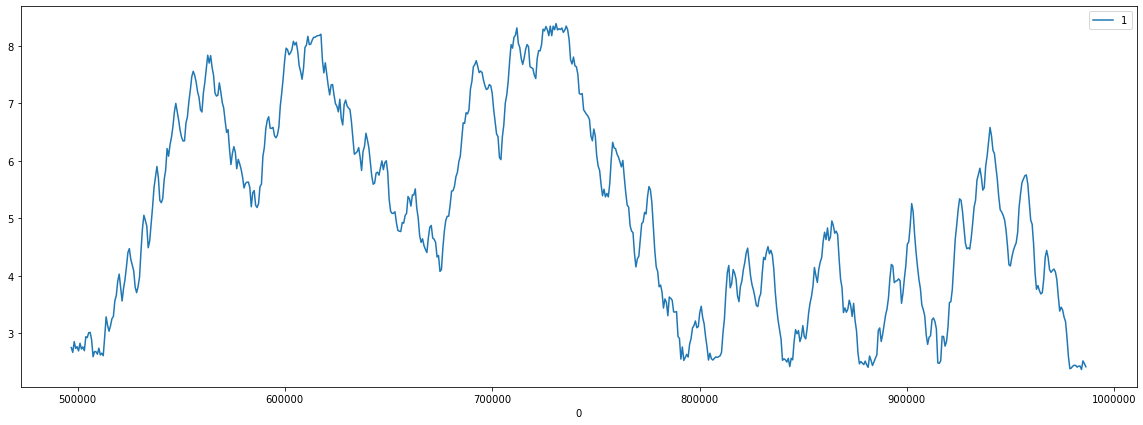

In [9]:
colvar.plot(0, 1);

Lack of facile movement across CV1 suggests the run has not converged yet as well.

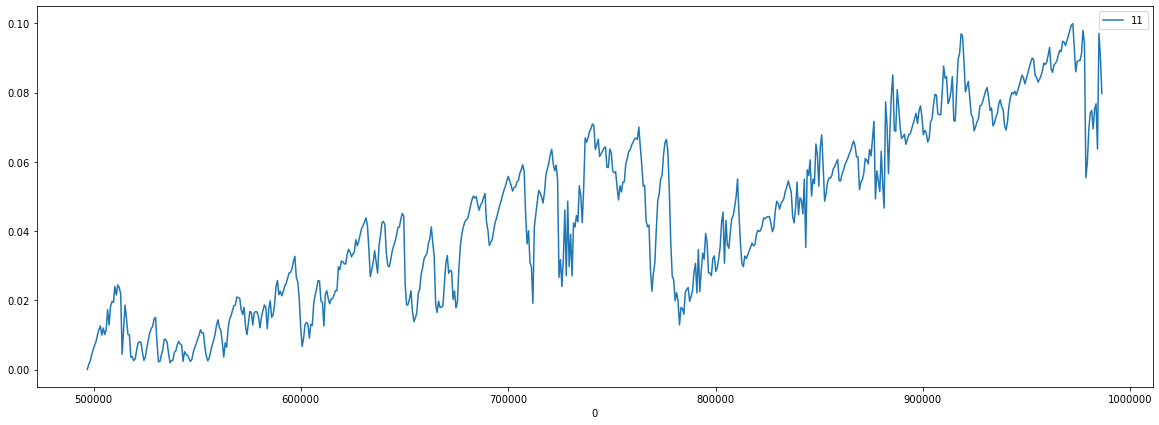

In [14]:
colvar.plot(0, 11);